# Conditional Average Treatment Effects (CATE) with DoWhy and EconML

This is an experimental feature where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

All four steps of causal inference in DoWhy remain the same: model, identify, estimate, and refute. The key difference is that we now call econml methods in the estimation step. There is also a simpler example using linear regression to understand the intuition behind CATE estimators. 

All datasets are generated using linear structural equations.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

BETA = 10

In [3]:
data = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
                                    num_discrete_common_causes=2,
                                    num_discrete_effect_modifiers=0,
                                    one_hot_encode=False)
df=data['df']
print(df.head())
print("True causal estimate is", data["ate"])

         X0        X1   Z0        Z1        W0        W1 W2 W3         v0  \
0  0.466924  0.545373  1.0  0.980580 -0.089920 -1.102966  1  2  29.142763   
1 -1.954197  1.301293  1.0  0.993879 -1.570227 -0.586380  3  1  31.981489   
2 -0.011379  1.018877  1.0  0.189473  0.786655 -1.565072  3  1  21.567235   
3 -0.337116  0.709103  1.0  0.136355  1.045159 -0.530799  0  3  22.153296   
4 -1.242242  0.749014  1.0  0.602660  0.108676 -0.829370  0  3  24.053723   

            y  
0  378.801494  
1  311.104074  
2  294.196086  
3  270.192567  
4  242.336445  
True causal estimate is 11.30974252808301


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

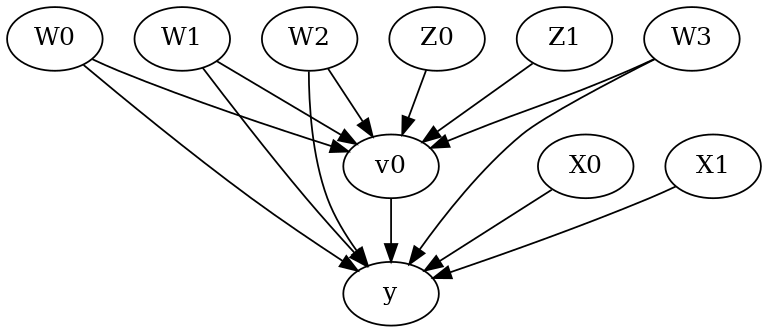

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Linear Model 
First, let us build some intuition using a linear model for estimating CATE. The effect modifiers (that lead to a heterogeneous treatment effect) can be modeled as interaction terms with the treatment. Thus, their value modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1. 

In [7]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

linear_regression


{'control_value': 0, 'treatment_value': 1, 'test_significance': None, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': ['X1', 'X0']}


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3+v0*X1+v0*X0
Target units: ate

## Estimate
Mean value: 11.309740579802678
### Conditional Estimates
__categorical__X1             __categorical__X0
(-2.6559999999999997, 0.135]  (-4.44, -1.551]       4.047931
                              (-1.551, -0.962]      6.084619
                              (-0.962, -0.459]      7.297869
                              (-0.459, 0.126]       8.442496
                              (0.126, 3.125]       10.140011
(0.135, 0.734]                (-4.44, -1.551]       6.699845
                              (-1.551, -0.962]      8.620767
                              (-0.962, -0.459]      9.74648

## EconML methods
We now move to the more advanced methods from the EconML package for estimating CATE.

First, let us look at the double machine learning estimator. Method_name corresponds to the fully qualified name of the class that we want to use. For double ML, it is "econml.dml.DML". 

Target units defines the units over which the causal estimate is to be computed. This can be a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). Below we show an example of a lambda function. 

Method_params are passed directly to EconML. For details on allowed parameters, refer to the EconML documentation. 

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 16.04277445973523
Effect estimates: [15.42830878 18.83137758 18.55111711 18.40122313 16.61218422 16.0327766
 23.69232089 11.33759682 15.10851233 13.05326091 18.95562608 24.19847755
 15.9827751  14.3846172  16.66855409 16.17474265 17.40839096 18.52171128
 12.4949672  17.57053486 17.96250994 14.40992409 17.04386126 16.77102521
 19.56421266 14.34026728 16.82581645 19.74460874 15.62955314 18.80913409
 21.24666383 16.76137698 17.70185113 15.56649195 17.43824357 22.41050981
 17.6084588  13.15434631 14.11018633 11.15145364 17.20572684 17.71500401
 19.893

In [9]:
print("True causal estimate is", data["ate"])

True causal estimate is 11.30974252808301


In [10]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X1,X0
Target units: 

## Estimate
Mean value: 11.285883905083686
Effect estimates: [12.62150067  9.49749007 12.97989576 ...  8.60342262  8.92582615
  9.63175324]



### CATE Object and Confidence Intervals
EconML provides its own methods to compute confidence intervals. Using BootstrapInference in the example below. 

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = "ate",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })
print(dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 11.276922454459871
Effect estimates: [12.634497    9.45917373 12.99867627 ...  8.55055852  8.87834202
  9.59573628]
95.0% confidence interval: (array([12.71140113,  9.40255996, 13.11074743, ...,  8.51101472,
        8.84817969,  9.61308466]), array([13.00128342,  9.7046824 , 13.35157336, ...,  8.72894971,
        9.05598215,  9.79199123]))



### Can provide a new inputs as target units and estimate CATE on them.

In [12]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DML",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

[10.60225879 13.11284947 14.67471786 14.58281271 11.03895294 12.49507439
 11.46043463 13.28905032 13.95714092 14.16794501]


### Can also retrieve the raw EconML estimator object for any further operations

In [13]:
print(dml_estimate._estimator_object)

## Works with any EconML method
In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

### Binary treatment, Binary outcome

In [14]:
data_binary = dowhy.datasets.linear_dataset(BETA, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

            X0        X1   Z0        Z1        W0        W1        W2  \
0    -0.641629  2.078366  1.0  0.526202  0.631724 -2.030900  1.182030   
1    -3.190200  0.740299  1.0  0.650114 -1.732311 -0.537791  0.850689   
2     0.342505  0.075854  1.0  0.076528  0.595340  1.448575 -0.475999   
3    -1.219300  1.479309  1.0  0.814266  0.456172  0.234804  1.048506   
4    -2.259805 -0.734023  1.0  0.509862 -2.432486 -0.644082 -0.202841   
...        ...       ...  ...       ...       ...       ...       ...   
9995 -0.943239  0.043411  1.0  0.764449 -0.583062 -0.647891  2.004966   
9996 -1.784707  1.293444  1.0  0.825683  1.420143 -0.393910  1.622557   
9997 -0.349167  0.537474  1.0  0.388474  0.970703 -2.469155  0.566863   
9998 -2.281351  0.511127  1.0  0.215142  0.953092 -0.654184 -1.300486   
9999 -0.177845  1.974618  1.0  0.111186  0.651507 -0.188221 -0.789300   

            W3  v0  y  
0     2.232193   1  1  
1    -0.629247   1  1  
2    -2.696255   1  1  
3     0.217729   1  1  
4  

#### Using DRLearner estimator

In [15]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)
print("True causal estimate is", data_binary["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                    
─────(E[y|W1,W2,W0,W3])
d[v₀]                  
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,U) = P(y|v0,W1,W2,W0,W3)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X1,X0
Target units: ate

## Estimate
Mean value: 0.36261850510067933
Effect estimates: [ 0.54089927  2.28118275 -0.53214408 ...  0.07145574  1.54813604
  0.16892802]

True causal estimate is 0.3517


### Instrumental Variable Method

In [16]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model.get_instruments())+len(model.get_effect_modifiers())
dims_tx = len(model._treatment)+len(model.get_effect_modifiers())
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIV",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

2022-08-18 15:34:23.723469: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-18 15:34:23.723515: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2022-08-18 15:34:25.462816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-18 15:34:25.462858: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-18 15:34:25.462884: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d715add5ae07): /proc/driver/nvidia/version does not exist
2022-08-18 15:34:25.463176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/25


  1/313 [..............................] - ETA: 4:07 - loss: 172.4182

 27/313 [=>............................] - ETA: 0s - loss: 68.9456   

 53/313 [====>.........................] - ETA: 0s - loss: 38.4205

 80/313 [======>.......................] - ETA: 0s - loss: 27.1798

106/313 [=========>....................] - ETA: 0s - loss: 21.7016

132/313 [===========>..................] - ETA: 0s - loss: 18.3547

158/313 [==============>...............] - ETA: 0s - loss: 16.0740

184/313 [================>.............] - ETA: 0s - loss: 14.4327

209/313 [===================>..........] - ETA: 0s - loss: 13.2337

235/313 [=====================>........] - ETA: 0s - loss: 12.2616

261/313 [========================>.....] - ETA: 0s - loss: 11.4616

287/313 [==========================>...] - ETA: 0s - loss: 10.8005

313/313 [==============================] - ETA: 0s - loss: 10.2475

313/313 [==============================] - 1s 2ms/step - loss: 10.2475


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 4.0642

 27/313 [=>............................] - ETA: 0s - loss: 4.1203

 52/313 [===>..........................] - ETA: 0s - loss: 4.1346

 77/313 [======>.......................] - ETA: 0s - loss: 4.1186

103/313 [========>.....................] - ETA: 0s - loss: 4.0965

129/313 [===========>..................] - ETA: 0s - loss: 4.0855

155/313 [=============>................] - ETA: 0s - loss: 4.0670

182/313 [================>.............] - ETA: 0s - loss: 4.0467

208/313 [==================>...........] - ETA: 0s - loss: 4.0246

234/313 [=====================>........] - ETA: 0s - loss: 3.9962

260/313 [=======================>......] - ETA: 0s - loss: 3.9723

286/313 [==========================>...] - ETA: 0s - loss: 3.9440

312/313 [============================>.] - ETA: 0s - loss: 3.9028

313/313 [==============================] - 1s 2ms/step - loss: 3.9005


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 2.9280

 27/313 [=>............................] - ETA: 0s - loss: 3.3138

 53/313 [====>.........................] - ETA: 0s - loss: 3.3182

 80/313 [======>.......................] - ETA: 0s - loss: 3.3095

106/313 [=========>....................] - ETA: 0s - loss: 3.2718

132/313 [===========>..................] - ETA: 0s - loss: 3.2660

158/313 [==============>...............] - ETA: 0s - loss: 3.2445

184/313 [================>.............] - ETA: 0s - loss: 3.2190

208/313 [==================>...........] - ETA: 0s - loss: 3.2011

233/313 [=====================>........] - ETA: 0s - loss: 3.1892

259/313 [=======================>......] - ETA: 0s - loss: 3.1804

285/313 [==========================>...] - ETA: 0s - loss: 3.1691

309/313 [============================>.] - ETA: 0s - loss: 3.1631

313/313 [==============================] - 1s 2ms/step - loss: 3.1627


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 2.9975

 26/313 [=>............................] - ETA: 0s - loss: 3.0285

 52/313 [===>..........................] - ETA: 0s - loss: 3.0535

 78/313 [======>.......................] - ETA: 0s - loss: 3.0505

104/313 [========>.....................] - ETA: 0s - loss: 3.0462

130/313 [===========>..................] - ETA: 0s - loss: 3.0348

154/313 [=============>................] - ETA: 0s - loss: 3.0324

179/313 [================>.............] - ETA: 0s - loss: 3.0311

206/313 [==================>...........] - ETA: 0s - loss: 3.0205

232/313 [=====================>........] - ETA: 0s - loss: 3.0199

254/313 [=======================>......] - ETA: 0s - loss: 3.0174

277/313 [=========================>....] - ETA: 0s - loss: 3.0099

302/313 [===========================>..] - ETA: 0s - loss: 3.0088

313/313 [==============================] - 1s 2ms/step - loss: 3.0071


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 2.8371

 27/313 [=>............................] - ETA: 0s - loss: 2.9251

 51/313 [===>..........................] - ETA: 0s - loss: 2.9452

 73/313 [=====>........................] - ETA: 0s - loss: 2.9225

 97/313 [========>.....................] - ETA: 0s - loss: 2.9535

122/313 [==========>...................] - ETA: 0s - loss: 2.9652

148/313 [=============>................] - ETA: 0s - loss: 2.9531

174/313 [===============>..............] - ETA: 0s - loss: 2.9454

200/313 [==================>...........] - ETA: 0s - loss: 2.9409

225/313 [====================>.........] - ETA: 0s - loss: 2.9404

251/313 [=======================>......] - ETA: 0s - loss: 2.9303

277/313 [=========================>....] - ETA: 0s - loss: 2.9352

303/313 [============================>.] - ETA: 0s - loss: 2.9352

313/313 [==============================] - 1s 2ms/step - loss: 2.9340


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 3.0534

 27/313 [=>............................] - ETA: 0s - loss: 2.8922

 53/313 [====>.........................] - ETA: 0s - loss: 2.8862

 79/313 [======>.......................] - ETA: 0s - loss: 2.8941

105/313 [=========>....................] - ETA: 0s - loss: 2.9048

131/313 [===========>..................] - ETA: 0s - loss: 2.8994

157/313 [==============>...............] - ETA: 0s - loss: 2.9054

183/313 [================>.............] - ETA: 0s - loss: 2.9042

210/313 [===================>..........] - ETA: 0s - loss: 2.9037

235/313 [=====================>........] - ETA: 0s - loss: 2.8965

261/313 [========================>.....] - ETA: 0s - loss: 2.8962

287/313 [==========================>...] - ETA: 0s - loss: 2.8970

312/313 [============================>.] - ETA: 0s - loss: 2.8970

313/313 [==============================] - 1s 2ms/step - loss: 2.8971


Epoch 7/25


  1/313 [..............................] - ETA: 1s - loss: 2.9517

 26/313 [=>............................] - ETA: 0s - loss: 2.8753

 52/313 [===>..........................] - ETA: 0s - loss: 2.8637

 78/313 [======>.......................] - ETA: 0s - loss: 2.8605

103/313 [========>.....................] - ETA: 0s - loss: 2.8564

128/313 [===========>..................] - ETA: 0s - loss: 2.8589

153/313 [=============>................] - ETA: 0s - loss: 2.8575

179/313 [================>.............] - ETA: 0s - loss: 2.8621

205/313 [==================>...........] - ETA: 0s - loss: 2.8684

231/313 [=====================>........] - ETA: 0s - loss: 2.8728

257/313 [=======================>......] - ETA: 0s - loss: 2.8743

284/313 [==========================>...] - ETA: 0s - loss: 2.8751

311/313 [============================>.] - ETA: 0s - loss: 2.8690

313/313 [==============================] - 1s 2ms/step - loss: 2.8681


Epoch 8/25


  1/313 [..............................] - ETA: 0s - loss: 2.7993

 27/313 [=>............................] - ETA: 0s - loss: 2.8174

 50/313 [===>..........................] - ETA: 0s - loss: 2.8264

 76/313 [======>.......................] - ETA: 0s - loss: 2.8426

102/313 [========>.....................] - ETA: 0s - loss: 2.8447

128/313 [===========>..................] - ETA: 0s - loss: 2.8390

154/313 [=============>................] - ETA: 0s - loss: 2.8354

179/313 [================>.............] - ETA: 0s - loss: 2.8429

206/313 [==================>...........] - ETA: 0s - loss: 2.8403

232/313 [=====================>........] - ETA: 0s - loss: 2.8421

259/313 [=======================>......] - ETA: 0s - loss: 2.8426

284/313 [==========================>...] - ETA: 0s - loss: 2.8400

310/313 [============================>.] - ETA: 0s - loss: 2.8413

313/313 [==============================] - 1s 2ms/step - loss: 2.8414


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 2.6995

 28/313 [=>............................] - ETA: 0s - loss: 2.8251

 54/313 [====>.........................] - ETA: 0s - loss: 2.8085

 79/313 [======>.......................] - ETA: 0s - loss: 2.8437

104/313 [========>.....................] - ETA: 0s - loss: 2.8393

129/313 [===========>..................] - ETA: 0s - loss: 2.8392

154/313 [=============>................] - ETA: 0s - loss: 2.8435

178/313 [================>.............] - ETA: 0s - loss: 2.8494

203/313 [==================>...........] - ETA: 0s - loss: 2.8456

228/313 [====================>.........] - ETA: 0s - loss: 2.8423

252/313 [=======================>......] - ETA: 0s - loss: 2.8339

278/313 [=========================>....] - ETA: 0s - loss: 2.8305

304/313 [============================>.] - ETA: 0s - loss: 2.8290

313/313 [==============================] - 1s 2ms/step - loss: 2.8296


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 3.0573

 28/313 [=>............................] - ETA: 0s - loss: 2.8342

 54/313 [====>.........................] - ETA: 0s - loss: 2.8304

 80/313 [======>.......................] - ETA: 0s - loss: 2.8266

106/313 [=========>....................] - ETA: 0s - loss: 2.8304

132/313 [===========>..................] - ETA: 0s - loss: 2.8261

158/313 [==============>...............] - ETA: 0s - loss: 2.8222

184/313 [================>.............] - ETA: 0s - loss: 2.8151

211/313 [===================>..........] - ETA: 0s - loss: 2.8074

238/313 [=====================>........] - ETA: 0s - loss: 2.8083

264/313 [========================>.....] - ETA: 0s - loss: 2.8052

290/313 [==========================>...] - ETA: 0s - loss: 2.8022

313/313 [==============================] - 1s 2ms/step - loss: 2.8025


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 2.9183

 26/313 [=>............................] - ETA: 0s - loss: 2.8095

 52/313 [===>..........................] - ETA: 0s - loss: 2.8007

 78/313 [======>.......................] - ETA: 0s - loss: 2.8188

105/313 [=========>....................] - ETA: 0s - loss: 2.8137

129/313 [===========>..................] - ETA: 0s - loss: 2.8114

153/313 [=============>................] - ETA: 0s - loss: 2.8087

177/313 [===============>..............] - ETA: 0s - loss: 2.8064

203/313 [==================>...........] - ETA: 0s - loss: 2.8103

228/313 [====================>.........] - ETA: 0s - loss: 2.8099

253/313 [=======================>......] - ETA: 0s - loss: 2.8062

279/313 [=========================>....] - ETA: 0s - loss: 2.8054

301/313 [===========================>..] - ETA: 0s - loss: 2.8038

313/313 [==============================] - 1s 2ms/step - loss: 2.8074


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 2.6838

 27/313 [=>............................] - ETA: 0s - loss: 2.7437

 53/313 [====>.........................] - ETA: 0s - loss: 2.7764

 79/313 [======>.......................] - ETA: 0s - loss: 2.7771

105/313 [=========>....................] - ETA: 0s - loss: 2.7775

131/313 [===========>..................] - ETA: 0s - loss: 2.7784

157/313 [==============>...............] - ETA: 0s - loss: 2.7815

184/313 [================>.............] - ETA: 0s - loss: 2.7863

210/313 [===================>..........] - ETA: 0s - loss: 2.7812

236/313 [=====================>........] - ETA: 0s - loss: 2.7834

262/313 [========================>.....] - ETA: 0s - loss: 2.7873

289/313 [==========================>...] - ETA: 0s - loss: 2.7885

313/313 [==============================] - 1s 2ms/step - loss: 2.7887


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 2.6544

 28/313 [=>............................] - ETA: 0s - loss: 2.8217

 53/313 [====>.........................] - ETA: 0s - loss: 2.8068

 80/313 [======>.......................] - ETA: 0s - loss: 2.8066

106/313 [=========>....................] - ETA: 0s - loss: 2.8052

131/313 [===========>..................] - ETA: 0s - loss: 2.8027

152/313 [=============>................] - ETA: 0s - loss: 2.7984

176/313 [===============>..............] - ETA: 0s - loss: 2.7954

201/313 [==================>...........] - ETA: 0s - loss: 2.7905

227/313 [====================>.........] - ETA: 0s - loss: 2.7816

253/313 [=======================>......] - ETA: 0s - loss: 2.7786

279/313 [=========================>....] - ETA: 0s - loss: 2.7791

304/313 [============================>.] - ETA: 0s - loss: 2.7764

313/313 [==============================] - 1s 2ms/step - loss: 2.7771


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 2.7134

 27/313 [=>............................] - ETA: 0s - loss: 2.7912

 51/313 [===>..........................] - ETA: 0s - loss: 2.7629

 75/313 [======>.......................] - ETA: 0s - loss: 2.7704

 97/313 [========>.....................] - ETA: 0s - loss: 2.7654

123/313 [==========>...................] - ETA: 0s - loss: 2.7615

148/313 [=============>................] - ETA: 0s - loss: 2.7607

174/313 [===============>..............] - ETA: 0s - loss: 2.7606

200/313 [==================>...........] - ETA: 0s - loss: 2.7636

225/313 [====================>.........] - ETA: 0s - loss: 2.7715

250/313 [======================>.......] - ETA: 0s - loss: 2.7702

276/313 [=========================>....] - ETA: 0s - loss: 2.7704

301/313 [===========================>..] - ETA: 0s - loss: 2.7708

313/313 [==============================] - 1s 2ms/step - loss: 2.7713


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 3.0092

 27/313 [=>............................] - ETA: 0s - loss: 2.7374

 53/313 [====>.........................] - ETA: 0s - loss: 2.7452

 80/313 [======>.......................] - ETA: 0s - loss: 2.7559

106/313 [=========>....................] - ETA: 0s - loss: 2.7701

132/313 [===========>..................] - ETA: 0s - loss: 2.7583

158/313 [==============>...............] - ETA: 0s - loss: 2.7521

184/313 [================>.............] - ETA: 0s - loss: 2.7617

210/313 [===================>..........] - ETA: 0s - loss: 2.7625

237/313 [=====================>........] - ETA: 0s - loss: 2.7640

264/313 [========================>.....] - ETA: 0s - loss: 2.7578

291/313 [==========================>...] - ETA: 0s - loss: 2.7577

313/313 [==============================] - 1s 2ms/step - loss: 2.7591


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 2.9564

 28/313 [=>............................] - ETA: 0s - loss: 2.7721

 54/313 [====>.........................] - ETA: 0s - loss: 2.7559

 80/313 [======>.......................] - ETA: 0s - loss: 2.7566

106/313 [=========>....................] - ETA: 0s - loss: 2.7466

131/313 [===========>..................] - ETA: 0s - loss: 2.7451

157/313 [==============>...............] - ETA: 0s - loss: 2.7422

183/313 [================>.............] - ETA: 0s - loss: 2.7373

207/313 [==================>...........] - ETA: 0s - loss: 2.7326

231/313 [=====================>........] - ETA: 0s - loss: 2.7338

252/313 [=======================>......] - ETA: 0s - loss: 2.7335

275/313 [=========================>....] - ETA: 0s - loss: 2.7331

301/313 [===========================>..] - ETA: 0s - loss: 2.7315

313/313 [==============================] - 1s 2ms/step - loss: 2.7321


Epoch 17/25


  1/313 [..............................] - ETA: 1s - loss: 2.8969

 24/313 [=>............................] - ETA: 0s - loss: 2.7160

 48/313 [===>..........................] - ETA: 0s - loss: 2.7205

 72/313 [=====>........................] - ETA: 0s - loss: 2.7281

 98/313 [========>.....................] - ETA: 0s - loss: 2.7306

124/313 [==========>...................] - ETA: 0s - loss: 2.7255

150/313 [=============>................] - ETA: 0s - loss: 2.7184

176/313 [===============>..............] - ETA: 0s - loss: 2.7127

202/313 [==================>...........] - ETA: 0s - loss: 2.7159

228/313 [====================>.........] - ETA: 0s - loss: 2.7171

254/313 [=======================>......] - ETA: 0s - loss: 2.7239

280/313 [=========================>....] - ETA: 0s - loss: 2.7232

306/313 [============================>.] - ETA: 0s - loss: 2.7248

313/313 [==============================] - 1s 2ms/step - loss: 2.7255


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 2.7563

 27/313 [=>............................] - ETA: 0s - loss: 2.6899

 53/313 [====>.........................] - ETA: 0s - loss: 2.6917

 79/313 [======>.......................] - ETA: 0s - loss: 2.6937

105/313 [=========>....................] - ETA: 0s - loss: 2.6958

131/313 [===========>..................] - ETA: 0s - loss: 2.7029

157/313 [==============>...............] - ETA: 0s - loss: 2.7080

183/313 [================>.............] - ETA: 0s - loss: 2.7075

210/313 [===================>..........] - ETA: 0s - loss: 2.7073

237/313 [=====================>........] - ETA: 0s - loss: 2.7085

264/313 [========================>.....] - ETA: 0s - loss: 2.7135

291/313 [==========================>...] - ETA: 0s - loss: 2.7134

313/313 [==============================] - 1s 2ms/step - loss: 2.7140


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 2.6881

 27/313 [=>............................] - ETA: 0s - loss: 2.7020

 53/313 [====>.........................] - ETA: 0s - loss: 2.7066

 80/313 [======>.......................] - ETA: 0s - loss: 2.6906

106/313 [=========>....................] - ETA: 0s - loss: 2.6921

132/313 [===========>..................] - ETA: 0s - loss: 2.6925

158/313 [==============>...............] - ETA: 0s - loss: 2.6925

184/313 [================>.............] - ETA: 0s - loss: 2.6937

210/313 [===================>..........] - ETA: 0s - loss: 2.6984

236/313 [=====================>........] - ETA: 0s - loss: 2.7028

262/313 [========================>.....] - ETA: 0s - loss: 2.7036

288/313 [==========================>...] - ETA: 0s - loss: 2.7067

313/313 [==============================] - 1s 2ms/step - loss: 2.7052


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 2.7115

 27/313 [=>............................] - ETA: 0s - loss: 2.6984

 51/313 [===>..........................] - ETA: 0s - loss: 2.7070

 78/313 [======>.......................] - ETA: 0s - loss: 2.7054

105/313 [=========>....................] - ETA: 0s - loss: 2.7105

129/313 [===========>..................] - ETA: 0s - loss: 2.7062

156/313 [=============>................] - ETA: 0s - loss: 2.7094

182/313 [================>.............] - ETA: 0s - loss: 2.7042

208/313 [==================>...........] - ETA: 0s - loss: 2.7058

234/313 [=====================>........] - ETA: 0s - loss: 2.7075

260/313 [=======================>......] - ETA: 0s - loss: 2.7051

286/313 [==========================>...] - ETA: 0s - loss: 2.7051

310/313 [============================>.] - ETA: 0s - loss: 2.7057

313/313 [==============================] - 1s 2ms/step - loss: 2.7050


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 2.5437

 25/313 [=>............................] - ETA: 0s - loss: 2.6746

 51/313 [===>..........................] - ETA: 0s - loss: 2.6703

 77/313 [======>.......................] - ETA: 0s - loss: 2.6778

103/313 [========>.....................] - ETA: 0s - loss: 2.6744

129/313 [===========>..................] - ETA: 0s - loss: 2.6812

154/313 [=============>................] - ETA: 0s - loss: 2.6879

176/313 [===============>..............] - ETA: 0s - loss: 2.6897

202/313 [==================>...........] - ETA: 0s - loss: 2.6915

228/313 [====================>.........] - ETA: 0s - loss: 2.6934

254/313 [=======================>......] - ETA: 0s - loss: 2.6917

280/313 [=========================>....] - ETA: 0s - loss: 2.6917

306/313 [============================>.] - ETA: 0s - loss: 2.6920

313/313 [==============================] - 1s 2ms/step - loss: 2.6905


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 2.7987

 27/313 [=>............................] - ETA: 0s - loss: 2.6897

 53/313 [====>.........................] - ETA: 0s - loss: 2.6790

 79/313 [======>.......................] - ETA: 0s - loss: 2.6932

105/313 [=========>....................] - ETA: 0s - loss: 2.6917

131/313 [===========>..................] - ETA: 0s - loss: 2.6890

157/313 [==============>...............] - ETA: 0s - loss: 2.6849

183/313 [================>.............] - ETA: 0s - loss: 2.6913

209/313 [===================>..........] - ETA: 0s - loss: 2.6905

235/313 [=====================>........] - ETA: 0s - loss: 2.6927

261/313 [========================>.....] - ETA: 0s - loss: 2.6906

287/313 [==========================>...] - ETA: 0s - loss: 2.6887

313/313 [==============================] - ETA: 0s - loss: 2.6875

313/313 [==============================] - 1s 2ms/step - loss: 2.6875


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 2.6950

 27/313 [=>............................] - ETA: 0s - loss: 2.6700

 53/313 [====>.........................] - ETA: 0s - loss: 2.6932

 78/313 [======>.......................] - ETA: 0s - loss: 2.6816

104/313 [========>.....................] - ETA: 0s - loss: 2.6892

130/313 [===========>..................] - ETA: 0s - loss: 2.6834

156/313 [=============>................] - ETA: 0s - loss: 2.6795

180/313 [================>.............] - ETA: 0s - loss: 2.6828

206/313 [==================>...........] - ETA: 0s - loss: 2.6863

232/313 [=====================>........] - ETA: 0s - loss: 2.6835

259/313 [=======================>......] - ETA: 0s - loss: 2.6812

285/313 [==========================>...] - ETA: 0s - loss: 2.6782

312/313 [============================>.] - ETA: 0s - loss: 2.6777

313/313 [==============================] - 1s 2ms/step - loss: 2.6787


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 2.5558

 26/313 [=>............................] - ETA: 0s - loss: 2.6455

 52/313 [===>..........................] - ETA: 0s - loss: 2.6739

 74/313 [======>.......................] - ETA: 0s - loss: 2.6695

 99/313 [========>.....................] - ETA: 0s - loss: 2.6699

123/313 [==========>...................] - ETA: 0s - loss: 2.6658

149/313 [=============>................] - ETA: 0s - loss: 2.6684

175/313 [===============>..............] - ETA: 0s - loss: 2.6708

201/313 [==================>...........] - ETA: 0s - loss: 2.6698

226/313 [====================>.........] - ETA: 0s - loss: 2.6686

252/313 [=======================>......] - ETA: 0s - loss: 2.6697

278/313 [=========================>....] - ETA: 0s - loss: 2.6721

304/313 [============================>.] - ETA: 0s - loss: 2.6757

313/313 [==============================] - 1s 2ms/step - loss: 2.6779


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 2.6870

 27/313 [=>............................] - ETA: 0s - loss: 2.6888

 53/313 [====>.........................] - ETA: 0s - loss: 2.6808

 75/313 [======>.......................] - ETA: 0s - loss: 2.6707

 99/313 [========>.....................] - ETA: 0s - loss: 2.6723

124/313 [==========>...................] - ETA: 0s - loss: 2.6704

150/313 [=============>................] - ETA: 0s - loss: 2.6718

174/313 [===============>..............] - ETA: 0s - loss: 2.6708

200/313 [==================>...........] - ETA: 0s - loss: 2.6688

226/313 [====================>.........] - ETA: 0s - loss: 2.6695

252/313 [=======================>......] - ETA: 0s - loss: 2.6685

277/313 [=========================>....] - ETA: 0s - loss: 2.6678

303/313 [============================>.] - ETA: 0s - loss: 2.6680

313/313 [==============================] - 1s 2ms/step - loss: 2.6669


Epoch 1/25


  1/313 [..............................] - ETA: 4:46 - loss: 71068.1094

 20/313 [>.............................] - ETA: 0s - loss: 87027.8672  

 40/313 [==>...........................] - ETA: 0s - loss: 77770.3125

 60/313 [====>.........................] - ETA: 0s - loss: 65277.0586

 80/313 [======>.......................] - ETA: 0s - loss: 55959.5625

101/313 [========>.....................] - ETA: 0s - loss: 49481.0898

122/313 [==========>...................] - ETA: 0s - loss: 45292.3086

144/313 [============>.................] - ETA: 0s - loss: 42571.3203

165/313 [==============>...............] - ETA: 0s - loss: 40643.1523

186/313 [================>.............] - ETA: 0s - loss: 38866.3711

207/313 [==================>...........] - ETA: 0s - loss: 37485.7148

228/313 [====================>.........] - ETA: 0s - loss: 36659.6836

249/313 [======================>.......] - ETA: 0s - loss: 35446.9375

269/313 [========================>.....] - ETA: 0s - loss: 34548.2539

290/313 [==========================>...] - ETA: 0s - loss: 33572.7812

311/313 [============================>.] - ETA: 0s - loss: 32643.9766

313/313 [==============================] - 2s 2ms/step - loss: 32547.8730


Epoch 2/25


  1/313 [..............................] - ETA: 1s - loss: 21446.8789

 22/313 [=>............................] - ETA: 0s - loss: 18859.9551

 43/313 [===>..........................] - ETA: 0s - loss: 19073.6387

 64/313 [=====>........................] - ETA: 0s - loss: 18996.4082

 85/313 [=======>......................] - ETA: 0s - loss: 18150.2168

105/313 [=========>....................] - ETA: 0s - loss: 17749.1426

124/313 [==========>...................] - ETA: 0s - loss: 17552.5430

145/313 [============>.................] - ETA: 0s - loss: 17434.9746

166/313 [==============>...............] - ETA: 0s - loss: 17213.8008

187/313 [================>.............] - ETA: 0s - loss: 17086.5176

209/313 [===================>..........] - ETA: 0s - loss: 16860.6152

230/313 [=====================>........] - ETA: 0s - loss: 16827.1387

251/313 [=======================>......] - ETA: 0s - loss: 16638.5723

271/313 [========================>.....] - ETA: 0s - loss: 16687.8027

291/313 [==========================>...] - ETA: 0s - loss: 16818.1504

312/313 [============================>.] - ETA: 0s - loss: 16889.1680

313/313 [==============================] - 1s 2ms/step - loss: 16921.4609


Epoch 3/25


  1/313 [..............................] - ETA: 1s - loss: 23602.4668

 23/313 [=>............................] - ETA: 0s - loss: 16439.2422

 42/313 [===>..........................] - ETA: 0s - loss: 15891.8145

 59/313 [====>.........................] - ETA: 0s - loss: 15738.5029

 77/313 [======>.......................] - ETA: 0s - loss: 15664.5977

 96/313 [========>.....................] - ETA: 0s - loss: 15920.5596

115/313 [==========>...................] - ETA: 0s - loss: 16303.0537

136/313 [============>.................] - ETA: 0s - loss: 16121.0850

157/313 [==============>...............] - ETA: 0s - loss: 16067.5840

179/313 [================>.............] - ETA: 0s - loss: 16230.6631

201/313 [==================>...........] - ETA: 0s - loss: 16049.2178

221/313 [====================>.........] - ETA: 0s - loss: 16015.6787

240/313 [======================>.......] - ETA: 0s - loss: 15785.7246

259/313 [=======================>......] - ETA: 0s - loss: 15735.3369

279/313 [=========================>....] - ETA: 0s - loss: 15680.5625

298/313 [===========================>..] - ETA: 0s - loss: 15766.4229

313/313 [==============================] - 1s 3ms/step - loss: 15770.6553


Epoch 4/25


  1/313 [..............................] - ETA: 1s - loss: 19020.1836

 19/313 [>.............................] - ETA: 0s - loss: 15168.9111

 37/313 [==>...........................] - ETA: 0s - loss: 15281.3984

 53/313 [====>.........................] - ETA: 0s - loss: 15716.2773

 72/313 [=====>........................] - ETA: 0s - loss: 14996.5537

 92/313 [=======>......................] - ETA: 0s - loss: 15027.8408

111/313 [=========>....................] - ETA: 0s - loss: 15030.1426

129/313 [===========>..................] - ETA: 0s - loss: 15226.3740

147/313 [=============>................] - ETA: 0s - loss: 15250.7207

165/313 [==============>...............] - ETA: 0s - loss: 15525.8633

182/313 [================>.............] - ETA: 0s - loss: 15527.6240

200/313 [==================>...........] - ETA: 0s - loss: 15557.0195

217/313 [===================>..........] - ETA: 0s - loss: 15465.6279

238/313 [=====================>........] - ETA: 0s - loss: 15517.6299

259/313 [=======================>......] - ETA: 0s - loss: 15543.5303

280/313 [=========================>....] - ETA: 0s - loss: 15489.4932

300/313 [===========================>..] - ETA: 0s - loss: 15401.8486

313/313 [==============================] - 1s 3ms/step - loss: 15304.9443


Epoch 5/25


  1/313 [..............................] - ETA: 1s - loss: 15186.8936

 22/313 [=>............................] - ETA: 0s - loss: 14646.2666

 42/313 [===>..........................] - ETA: 0s - loss: 14347.7617

 63/313 [=====>........................] - ETA: 0s - loss: 14513.1582

 85/313 [=======>......................] - ETA: 0s - loss: 14593.2002

106/313 [=========>....................] - ETA: 0s - loss: 14450.5498

126/313 [===========>..................] - ETA: 0s - loss: 14810.1445

146/313 [============>.................] - ETA: 0s - loss: 14769.1904

166/313 [==============>...............] - ETA: 0s - loss: 14725.6465

186/313 [================>.............] - ETA: 0s - loss: 14702.0713

203/313 [==================>...........] - ETA: 0s - loss: 14707.3926

222/313 [====================>.........] - ETA: 0s - loss: 14686.6553

243/313 [======================>.......] - ETA: 0s - loss: 14978.4473

263/313 [========================>.....] - ETA: 0s - loss: 14902.0752

283/313 [==========================>...] - ETA: 0s - loss: 15029.8389

304/313 [============================>.] - ETA: 0s - loss: 15050.4082

313/313 [==============================] - 1s 3ms/step - loss: 15038.8262


Epoch 6/25


  1/313 [..............................] - ETA: 1s - loss: 10969.7256

 23/313 [=>............................] - ETA: 0s - loss: 13805.4072

 42/313 [===>..........................] - ETA: 0s - loss: 13523.9404

 63/313 [=====>........................] - ETA: 0s - loss: 14505.4023

 82/313 [======>.......................] - ETA: 0s - loss: 14752.4434

101/313 [========>.....................] - ETA: 0s - loss: 14768.4971

120/313 [==========>...................] - ETA: 0s - loss: 14865.4521

140/313 [============>.................] - ETA: 0s - loss: 14661.0801

161/313 [==============>...............] - ETA: 0s - loss: 14626.7363

182/313 [================>.............] - ETA: 0s - loss: 14684.5137

203/313 [==================>...........] - ETA: 0s - loss: 14902.2139

223/313 [====================>.........] - ETA: 0s - loss: 15009.5000

243/313 [======================>.......] - ETA: 0s - loss: 15056.7656

261/313 [========================>.....] - ETA: 0s - loss: 15045.2832

279/313 [=========================>....] - ETA: 0s - loss: 15031.5322

297/313 [===========================>..] - ETA: 0s - loss: 14952.1973

313/313 [==============================] - 1s 3ms/step - loss: 15110.6260


Epoch 7/25


  1/313 [..............................] - ETA: 2s - loss: 10554.1260

 19/313 [>.............................] - ETA: 0s - loss: 14647.3311

 35/313 [==>...........................] - ETA: 0s - loss: 14317.8975

 53/313 [====>.........................] - ETA: 0s - loss: 14377.1553

 73/313 [=====>........................] - ETA: 0s - loss: 14544.7949

 94/313 [========>.....................] - ETA: 0s - loss: 14928.0215

115/313 [==========>...................] - ETA: 0s - loss: 14963.0312

136/313 [============>.................] - ETA: 0s - loss: 14762.6758

156/313 [=============>................] - ETA: 0s - loss: 15081.2002

176/313 [===============>..............] - ETA: 0s - loss: 15081.9561

197/313 [=================>............] - ETA: 0s - loss: 15169.8145

217/313 [===================>..........] - ETA: 0s - loss: 15138.3936

238/313 [=====================>........] - ETA: 0s - loss: 15169.7666

258/313 [=======================>......] - ETA: 0s - loss: 15171.1270

278/313 [=========================>....] - ETA: 0s - loss: 15075.9541

299/313 [===========================>..] - ETA: 0s - loss: 15045.6641

313/313 [==============================] - 1s 3ms/step - loss: 15007.0127


Epoch 8/25


  1/313 [..............................] - ETA: 1s - loss: 15135.7617

 23/313 [=>............................] - ETA: 0s - loss: 13841.6104

 44/313 [===>..........................] - ETA: 0s - loss: 14560.7715

 65/313 [=====>........................] - ETA: 0s - loss: 14647.2676

 86/313 [=======>......................] - ETA: 0s - loss: 14531.5801

107/313 [=========>....................] - ETA: 0s - loss: 14815.1240

128/313 [===========>..................] - ETA: 0s - loss: 14944.5156

149/313 [=============>................] - ETA: 0s - loss: 15009.7285

169/313 [===============>..............] - ETA: 0s - loss: 15207.5957

188/313 [=================>............] - ETA: 0s - loss: 15059.4336

209/313 [===================>..........] - ETA: 0s - loss: 14911.6670

229/313 [====================>.........] - ETA: 0s - loss: 14756.5547

250/313 [======================>.......] - ETA: 0s - loss: 14813.2773

270/313 [========================>.....] - ETA: 0s - loss: 14883.8242

289/313 [==========================>...] - ETA: 0s - loss: 14874.1543

309/313 [============================>.] - ETA: 0s - loss: 14893.0664

313/313 [==============================] - 1s 2ms/step - loss: 14862.7891


Epoch 9/25


  1/313 [..............................] - ETA: 1s - loss: 19564.1289

 22/313 [=>............................] - ETA: 0s - loss: 14832.4072

 43/313 [===>..........................] - ETA: 0s - loss: 15111.0781

 64/313 [=====>........................] - ETA: 0s - loss: 14953.9629

 85/313 [=======>......................] - ETA: 0s - loss: 14823.0488

107/313 [=========>....................] - ETA: 0s - loss: 14548.3613

128/313 [===========>..................] - ETA: 0s - loss: 14422.0469

149/313 [=============>................] - ETA: 0s - loss: 14622.7646

170/313 [===============>..............] - ETA: 0s - loss: 14597.7520

190/313 [=================>............] - ETA: 0s - loss: 14706.1670

211/313 [===================>..........] - ETA: 0s - loss: 14684.6318

232/313 [=====================>........] - ETA: 0s - loss: 14878.1885

253/313 [=======================>......] - ETA: 0s - loss: 14901.3242

274/313 [=========================>....] - ETA: 0s - loss: 14885.1230

296/313 [===========================>..] - ETA: 0s - loss: 14834.0625

313/313 [==============================] - 1s 2ms/step - loss: 14845.4717


Epoch 10/25


  1/313 [..............................] - ETA: 1s - loss: 21988.6523

 22/313 [=>............................] - ETA: 0s - loss: 16090.1807

 44/313 [===>..........................] - ETA: 0s - loss: 15555.5664

 66/313 [=====>........................] - ETA: 0s - loss: 15478.6631

 87/313 [=======>......................] - ETA: 0s - loss: 15261.2646

108/313 [=========>....................] - ETA: 0s - loss: 14992.0049

129/313 [===========>..................] - ETA: 0s - loss: 14693.6592

150/313 [=============>................] - ETA: 0s - loss: 14733.8555

172/313 [===============>..............] - ETA: 0s - loss: 14744.5752

194/313 [=================>............] - ETA: 0s - loss: 15232.1904

214/313 [===================>..........] - ETA: 0s - loss: 15275.6689

235/313 [=====================>........] - ETA: 0s - loss: 15411.0664

256/313 [=======================>......] - ETA: 0s - loss: 15292.1514

277/313 [=========================>....] - ETA: 0s - loss: 15199.5957

298/313 [===========================>..] - ETA: 0s - loss: 15152.6865

313/313 [==============================] - 1s 2ms/step - loss: 15086.4951


Epoch 11/25


  1/313 [..............................] - ETA: 1s - loss: 8647.6562

 22/313 [=>............................] - ETA: 0s - loss: 14401.0059

 43/313 [===>..........................] - ETA: 0s - loss: 15681.2734

 64/313 [=====>........................] - ETA: 0s - loss: 14967.9717

 85/313 [=======>......................] - ETA: 0s - loss: 15003.9854

107/313 [=========>....................] - ETA: 0s - loss: 14696.5479

128/313 [===========>..................] - ETA: 0s - loss: 14721.5410

149/313 [=============>................] - ETA: 0s - loss: 14887.5791

170/313 [===============>..............] - ETA: 0s - loss: 14941.0605

191/313 [=================>............] - ETA: 0s - loss: 15076.5986

213/313 [===================>..........] - ETA: 0s - loss: 15069.8066

235/313 [=====================>........] - ETA: 0s - loss: 15018.4785

256/313 [=======================>......] - ETA: 0s - loss: 15074.3770

278/313 [=========================>....] - ETA: 0s - loss: 15151.1260

300/313 [===========================>..] - ETA: 0s - loss: 15085.3652

313/313 [==============================] - 1s 2ms/step - loss: 15067.3877


Epoch 12/25


  1/313 [..............................] - ETA: 1s - loss: 11443.0449

 21/313 [=>............................] - ETA: 0s - loss: 14639.2051

 41/313 [==>...........................] - ETA: 0s - loss: 14804.7412

 60/313 [====>.........................] - ETA: 0s - loss: 14197.3945

 79/313 [======>.......................] - ETA: 0s - loss: 14988.3848

100/313 [========>.....................] - ETA: 0s - loss: 15242.6377

116/313 [==========>...................] - ETA: 0s - loss: 15240.2432

135/313 [===========>..................] - ETA: 0s - loss: 15098.2012

152/313 [=============>................] - ETA: 0s - loss: 15016.7695

168/313 [===============>..............] - ETA: 0s - loss: 15109.9941

187/313 [================>.............] - ETA: 0s - loss: 15027.4590

207/313 [==================>...........] - ETA: 0s - loss: 14997.8359

226/313 [====================>.........] - ETA: 0s - loss: 14872.6328

247/313 [======================>.......] - ETA: 0s - loss: 14858.4170

268/313 [========================>.....] - ETA: 0s - loss: 14871.1113

290/313 [==========================>...] - ETA: 0s - loss: 14833.9072

312/313 [============================>.] - ETA: 0s - loss: 14864.1846

313/313 [==============================] - 1s 3ms/step - loss: 14894.8896


Epoch 13/25


  1/313 [..............................] - ETA: 1s - loss: 12810.4746

 22/313 [=>............................] - ETA: 0s - loss: 14348.7197

 42/313 [===>..........................] - ETA: 0s - loss: 14715.5117

 61/313 [====>.........................] - ETA: 0s - loss: 14642.2969

 80/313 [======>.......................] - ETA: 0s - loss: 14649.0908

 98/313 [========>.....................] - ETA: 0s - loss: 14637.5840

118/313 [==========>...................] - ETA: 0s - loss: 14525.8193

139/313 [============>.................] - ETA: 0s - loss: 14838.3574

161/313 [==============>...............] - ETA: 0s - loss: 14944.8389

182/313 [================>.............] - ETA: 0s - loss: 14871.2129

204/313 [==================>...........] - ETA: 0s - loss: 14917.4658

225/313 [====================>.........] - ETA: 0s - loss: 14835.5625

247/313 [======================>.......] - ETA: 0s - loss: 14746.2979

269/313 [========================>.....] - ETA: 0s - loss: 14714.2637

290/313 [==========================>...] - ETA: 0s - loss: 14804.7344

312/313 [============================>.] - ETA: 0s - loss: 14845.9404

313/313 [==============================] - 1s 2ms/step - loss: 14819.3994


Epoch 14/25


  1/313 [..............................] - ETA: 1s - loss: 11018.7285

 22/313 [=>............................] - ETA: 0s - loss: 14913.0938

 42/313 [===>..........................] - ETA: 0s - loss: 14633.3037

 62/313 [====>.........................] - ETA: 0s - loss: 14558.0957

 82/313 [======>.......................] - ETA: 0s - loss: 14248.8975

102/313 [========>.....................] - ETA: 0s - loss: 14384.7734

123/313 [==========>...................] - ETA: 0s - loss: 14299.2910

145/313 [============>.................] - ETA: 0s - loss: 14690.3018

165/313 [==============>...............] - ETA: 0s - loss: 14534.2861

185/313 [================>.............] - ETA: 0s - loss: 14742.7959

205/313 [==================>...........] - ETA: 0s - loss: 14893.7061

226/313 [====================>.........] - ETA: 0s - loss: 14924.8350

247/313 [======================>.......] - ETA: 0s - loss: 14926.7412

266/313 [========================>.....] - ETA: 0s - loss: 14939.6855

287/313 [==========================>...] - ETA: 0s - loss: 14810.5000

308/313 [============================>.] - ETA: 0s - loss: 14746.1543

313/313 [==============================] - 1s 2ms/step - loss: 14813.4053


Epoch 15/25


  1/313 [..............................] - ETA: 1s - loss: 10523.8818

 22/313 [=>............................] - ETA: 0s - loss: 14277.3213

 40/313 [==>...........................] - ETA: 0s - loss: 14496.8145

 58/313 [====>.........................] - ETA: 0s - loss: 14205.9521

 75/313 [======>.......................] - ETA: 0s - loss: 14606.5996

 92/313 [=======>......................] - ETA: 0s - loss: 14220.4229

109/313 [=========>....................] - ETA: 0s - loss: 13989.6465

128/313 [===========>..................] - ETA: 0s - loss: 14076.3164

149/313 [=============>................] - ETA: 0s - loss: 14391.3486

169/313 [===============>..............] - ETA: 0s - loss: 14532.6318

191/313 [=================>............] - ETA: 0s - loss: 14733.9463

211/313 [===================>..........] - ETA: 0s - loss: 14687.3281

232/313 [=====================>........] - ETA: 0s - loss: 14804.6377

253/313 [=======================>......] - ETA: 0s - loss: 14766.7178

274/313 [=========================>....] - ETA: 0s - loss: 14729.5781

294/313 [===========================>..] - ETA: 0s - loss: 14674.9521

313/313 [==============================] - 1s 3ms/step - loss: 14739.4199


Epoch 16/25


  1/313 [..............................] - ETA: 1s - loss: 16202.8018

 22/313 [=>............................] - ETA: 0s - loss: 15766.8779

 43/313 [===>..........................] - ETA: 0s - loss: 14733.3545

 63/313 [=====>........................] - ETA: 0s - loss: 14974.9980

 84/313 [=======>......................] - ETA: 0s - loss: 15030.7676

105/313 [=========>....................] - ETA: 0s - loss: 14945.1270

126/313 [===========>..................] - ETA: 0s - loss: 15092.4072

148/313 [=============>................] - ETA: 0s - loss: 14975.7217

169/313 [===============>..............] - ETA: 0s - loss: 14836.1240

188/313 [=================>............] - ETA: 0s - loss: 14900.0996

208/313 [==================>...........] - ETA: 0s - loss: 14973.9824

228/313 [====================>.........] - ETA: 0s - loss: 15008.3301

248/313 [======================>.......] - ETA: 0s - loss: 14902.8545

268/313 [========================>.....] - ETA: 0s - loss: 14757.6260

289/313 [==========================>...] - ETA: 0s - loss: 14656.5361

304/313 [============================>.] - ETA: 0s - loss: 14704.6064

313/313 [==============================] - 1s 3ms/step - loss: 14828.8643


Epoch 17/25


  1/313 [..............................] - ETA: 3s - loss: 9621.6318

 20/313 [>.............................] - ETA: 0s - loss: 14320.2344

 39/313 [==>...........................] - ETA: 0s - loss: 14920.9443

 58/313 [====>.........................] - ETA: 0s - loss: 15757.4287

 75/313 [======>.......................] - ETA: 0s - loss: 15136.5518

 92/313 [=======>......................] - ETA: 0s - loss: 15242.5840

110/313 [=========>....................] - ETA: 0s - loss: 14868.9395

129/313 [===========>..................] - ETA: 0s - loss: 14773.1182

146/313 [============>.................] - ETA: 0s - loss: 14723.9141

166/313 [==============>...............] - ETA: 0s - loss: 14657.0020

185/313 [================>.............] - ETA: 0s - loss: 14836.3779

207/313 [==================>...........] - ETA: 0s - loss: 14900.4199

229/313 [====================>.........] - ETA: 0s - loss: 15129.9502

250/313 [======================>.......] - ETA: 0s - loss: 15012.8701

270/313 [========================>.....] - ETA: 0s - loss: 14976.7568

291/313 [==========================>...] - ETA: 0s - loss: 14890.2031

311/313 [============================>.] - ETA: 0s - loss: 14918.1572

313/313 [==============================] - 1s 3ms/step - loss: 14915.6436


Epoch 18/25


  1/313 [..............................] - ETA: 1s - loss: 18958.6719

 22/313 [=>............................] - ETA: 0s - loss: 14899.8604

 43/313 [===>..........................] - ETA: 0s - loss: 15065.4551

 64/313 [=====>........................] - ETA: 0s - loss: 15027.8477

 85/313 [=======>......................] - ETA: 0s - loss: 15060.6270

106/313 [=========>....................] - ETA: 0s - loss: 14871.5977

127/313 [===========>..................] - ETA: 0s - loss: 14722.4355

147/313 [=============>................] - ETA: 0s - loss: 14749.9307

167/313 [===============>..............] - ETA: 0s - loss: 14801.3604

188/313 [=================>............] - ETA: 0s - loss: 14674.4160

209/313 [===================>..........] - ETA: 0s - loss: 14697.6289

230/313 [=====================>........] - ETA: 0s - loss: 14718.5469

251/313 [=======================>......] - ETA: 0s - loss: 14720.8721

273/313 [=========================>....] - ETA: 0s - loss: 14787.2646

295/313 [===========================>..] - ETA: 0s - loss: 14837.9150

313/313 [==============================] - 1s 2ms/step - loss: 14906.2510


Epoch 19/25


  1/313 [..............................] - ETA: 1s - loss: 18405.1680

 21/313 [=>............................] - ETA: 0s - loss: 13883.2754

 42/313 [===>..........................] - ETA: 0s - loss: 14702.7754

 63/313 [=====>........................] - ETA: 0s - loss: 14699.5791

 85/313 [=======>......................] - ETA: 0s - loss: 14520.0293

106/313 [=========>....................] - ETA: 0s - loss: 14801.4648

127/313 [===========>..................] - ETA: 0s - loss: 14675.5850

147/313 [=============>................] - ETA: 0s - loss: 14756.8828

168/313 [===============>..............] - ETA: 0s - loss: 14726.1328

189/313 [=================>............] - ETA: 0s - loss: 14678.8623

209/313 [===================>..........] - ETA: 0s - loss: 14689.2383

228/313 [====================>.........] - ETA: 0s - loss: 14729.4844

247/313 [======================>.......] - ETA: 0s - loss: 14723.2998

266/313 [========================>.....] - ETA: 0s - loss: 14745.9834

284/313 [==========================>...] - ETA: 0s - loss: 14801.7188

302/313 [===========================>..] - ETA: 0s - loss: 14812.1172

313/313 [==============================] - 1s 3ms/step - loss: 14709.8115


Epoch 20/25


  1/313 [..............................] - ETA: 1s - loss: 17904.1719

 22/313 [=>............................] - ETA: 0s - loss: 16030.1035

 43/313 [===>..........................] - ETA: 0s - loss: 15206.9043

 61/313 [====>.........................] - ETA: 0s - loss: 14893.0117

 81/313 [======>.......................] - ETA: 0s - loss: 14695.5049

101/313 [========>.....................] - ETA: 0s - loss: 14444.0977

122/313 [==========>...................] - ETA: 0s - loss: 14352.0244

142/313 [============>.................] - ETA: 0s - loss: 14225.6416

163/313 [==============>...............] - ETA: 0s - loss: 14250.1348

183/313 [================>.............] - ETA: 0s - loss: 14209.8516

203/313 [==================>...........] - ETA: 0s - loss: 14185.1211

223/313 [====================>.........] - ETA: 0s - loss: 14340.0273

244/313 [======================>.......] - ETA: 0s - loss: 14353.2227

265/313 [========================>.....] - ETA: 0s - loss: 14319.2012

286/313 [==========================>...] - ETA: 0s - loss: 14306.1104

307/313 [============================>.] - ETA: 0s - loss: 14402.5361

313/313 [==============================] - 1s 3ms/step - loss: 14427.6904


Epoch 21/25


  1/313 [..............................] - ETA: 1s - loss: 29109.3242

 22/313 [=>............................] - ETA: 0s - loss: 15719.5381

 43/313 [===>..........................] - ETA: 0s - loss: 14932.4336

 64/313 [=====>........................] - ETA: 0s - loss: 14594.9678

 85/313 [=======>......................] - ETA: 0s - loss: 15295.4092

106/313 [=========>....................] - ETA: 0s - loss: 15349.6406

127/313 [===========>..................] - ETA: 0s - loss: 15159.3174

148/313 [=============>................] - ETA: 0s - loss: 14967.5156

169/313 [===============>..............] - ETA: 0s - loss: 14897.5254

190/313 [=================>............] - ETA: 0s - loss: 15047.7617

211/313 [===================>..........] - ETA: 0s - loss: 15119.2539

231/313 [=====================>........] - ETA: 0s - loss: 15075.0762

249/313 [======================>.......] - ETA: 0s - loss: 15153.0430

268/313 [========================>.....] - ETA: 0s - loss: 15129.0713

289/313 [==========================>...] - ETA: 0s - loss: 15031.8252

310/313 [============================>.] - ETA: 0s - loss: 14966.1641

313/313 [==============================] - 1s 2ms/step - loss: 14946.2314


Epoch 22/25


  1/313 [..............................] - ETA: 1s - loss: 11520.4805

 22/313 [=>............................] - ETA: 0s - loss: 14138.3604

 43/313 [===>..........................] - ETA: 0s - loss: 14552.6523

 63/313 [=====>........................] - ETA: 0s - loss: 14480.2100

 84/313 [=======>......................] - ETA: 0s - loss: 14597.8721

105/313 [=========>....................] - ETA: 0s - loss: 14490.4912

125/313 [==========>...................] - ETA: 0s - loss: 14681.5244

146/313 [============>.................] - ETA: 0s - loss: 14656.7070

167/313 [===============>..............] - ETA: 0s - loss: 14651.4980

187/313 [================>.............] - ETA: 0s - loss: 14686.8770

206/313 [==================>...........] - ETA: 0s - loss: 14733.2656

226/313 [====================>.........] - ETA: 0s - loss: 14625.6826

247/313 [======================>.......] - ETA: 0s - loss: 14697.7725

268/313 [========================>.....] - ETA: 0s - loss: 14696.3906

288/313 [==========================>...] - ETA: 0s - loss: 14737.2881

309/313 [============================>.] - ETA: 0s - loss: 14811.6572

313/313 [==============================] - 1s 2ms/step - loss: 14797.1602


Epoch 23/25


  1/313 [..............................] - ETA: 1s - loss: 21636.2812

 23/313 [=>............................] - ETA: 0s - loss: 15422.7783

 42/313 [===>..........................] - ETA: 0s - loss: 14931.0479

 63/313 [=====>........................] - ETA: 0s - loss: 14937.6816

 85/313 [=======>......................] - ETA: 0s - loss: 14802.3467

107/313 [=========>....................] - ETA: 0s - loss: 14689.9824

127/313 [===========>..................] - ETA: 0s - loss: 14717.5020

147/313 [=============>................] - ETA: 0s - loss: 15105.4375

166/313 [==============>...............] - ETA: 0s - loss: 14992.5439

187/313 [================>.............] - ETA: 0s - loss: 15017.6445

208/313 [==================>...........] - ETA: 0s - loss: 14975.4102

229/313 [====================>.........] - ETA: 0s - loss: 14936.3740

250/313 [======================>.......] - ETA: 0s - loss: 14957.0137

272/313 [=========================>....] - ETA: 0s - loss: 14939.7070

293/313 [===========================>..] - ETA: 0s - loss: 14891.8750

313/313 [==============================] - ETA: 0s - loss: 14846.6250

313/313 [==============================] - 1s 2ms/step - loss: 14846.6250


Epoch 24/25


  1/313 [..............................] - ETA: 1s - loss: 19152.9824

 22/313 [=>............................] - ETA: 0s - loss: 14393.4854

 42/313 [===>..........................] - ETA: 0s - loss: 14141.0732

 63/313 [=====>........................] - ETA: 0s - loss: 14753.1260

 84/313 [=======>......................] - ETA: 0s - loss: 14668.1445

105/313 [=========>....................] - ETA: 0s - loss: 14872.1299

125/313 [==========>...................] - ETA: 0s - loss: 14677.1289

144/313 [============>.................] - ETA: 0s - loss: 14669.1514

165/313 [==============>...............] - ETA: 0s - loss: 14708.9404

186/313 [================>.............] - ETA: 0s - loss: 14785.2178

207/313 [==================>...........] - ETA: 0s - loss: 14949.4316

228/313 [====================>.........] - ETA: 0s - loss: 14967.2158

249/313 [======================>.......] - ETA: 0s - loss: 14896.7812

268/313 [========================>.....] - ETA: 0s - loss: 14872.1182

289/313 [==========================>...] - ETA: 0s - loss: 14865.5342

307/313 [============================>.] - ETA: 0s - loss: 14825.3242

313/313 [==============================] - 1s 3ms/step - loss: 14835.3115


Epoch 25/25


  1/313 [..............................] - ETA: 1s - loss: 9650.2705

 20/313 [>.............................] - ETA: 0s - loss: 14873.2920

 41/313 [==>...........................] - ETA: 0s - loss: 14214.1963

 62/313 [====>.........................] - ETA: 0s - loss: 14253.4395

 83/313 [======>.......................] - ETA: 0s - loss: 14297.3584

104/313 [========>.....................] - ETA: 0s - loss: 14264.1934

125/313 [==========>...................] - ETA: 0s - loss: 14216.5430

146/313 [============>.................] - ETA: 0s - loss: 14228.3984

166/313 [==============>...............] - ETA: 0s - loss: 14262.5723

186/313 [================>.............] - ETA: 0s - loss: 14301.7852

205/313 [==================>...........] - ETA: 0s - loss: 14422.4766

227/313 [====================>.........] - ETA: 0s - loss: 14432.2471

249/313 [======================>.......] - ETA: 0s - loss: 14516.6631

270/313 [========================>.....] - ETA: 0s - loss: 14450.3965

291/313 [==========================>...] - ETA: 0s - loss: 14498.2578

312/313 [============================>.] - ETA: 0s - loss: 14586.3350

313/313 [==============================] - 1s 2ms/step - loss: 14576.0146


The following Variables were used a Lambda layer's call (lambda_7), but
are not present in its tracked objects:
  <tf.Variable 'dense_3/kernel:0' shape=(3, 128) dtype=float32>
  <tf.Variable 'dense_3/bias:0' shape=(128,) dtype=float32>
  <tf.Variable 'dense_4/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'dense_4/bias:0' shape=(64,) dtype=float32>
  <tf.Variable 'dense_5/kernel:0' shape=(64, 32) dtype=float32>
  <tf.Variable 'dense_5/bias:0' shape=(32,) dtype=float32>
  <tf.Variable 'dense_6/kernel:0' shape=(32, 1) dtype=float32>
  <tf.Variable 'dense_6/bias:0' shape=(1,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


  1/192 [..............................] - ETA: 17s

 50/192 [======>.......................] - ETA: 0s 

 99/192 [==============>...............] - ETA: 0s

147/192 [=====================>........] - ETA: 0s

192/192 [==============================] - 0s 1ms/step


  1/192 [..............................] - ETA: 3s

 42/192 [=====>........................] - ETA: 0s

 91/192 [=============>................] - ETA: 0s

142/192 [=====================>........] - ETA: 0s

192/192 [==============================] - 0s 1ms/step


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₀  Z₁]    ⎝d[Z₀  Z₁]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W1+W2+W0+W3 | X1,X0
Target units: Data subset defined by a function

## Estimate
Mean value: 3.6258087158203125
Effect estimates: [ 6.149338   4.120453   3.7902527 ...  5.9155426 -1.5993042  3.212616 ]



### Metalearners

In [17]:
data_experiment = dowhy.datasets.linear_dataset(BETA, num_common_causes=5, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=5,
                                    treatment_is_binary=True, outcome_is_binary=False)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
print(data_experiment['df'])
model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

            X0        X1        X2        X3        X4   Z0        Z1  \
0     0.003557 -0.858680 -0.007393  0.293604 -0.140593  1.0  0.620162   
1     0.028005 -0.696383  1.800218  0.111446  0.697877  0.0  0.854639   
2     1.660941 -0.001841 -0.856934 -2.197362 -0.099238  1.0  0.711814   
3     1.231845 -0.836684  2.216650 -0.390333 -0.441888  0.0  0.552441   
4     1.808699  0.535813  0.039762  0.113416  1.016317  1.0  0.593161   
...        ...       ...       ...       ...       ...  ...       ...   
9995  0.152845  0.657241  2.205122 -0.131609  0.237882  1.0  0.835074   
9996  1.001744 -0.198308  1.431244 -0.000639  0.772281  0.0  0.269354   
9997 -1.065868  0.256638 -1.962730 -1.305271 -1.029430  0.0  0.284889   
9998  0.464644  0.536702 -0.654261 -0.468356 -1.154951  1.0  0.125912   
9999  1.430233  1.791345  0.051781 -1.298422  0.655930  0.0  0.763325   

            W0        W1        W2        W3        W4  v0          y  
0    -1.471558  1.109572  0.049697 -1.353575  0.810

In [18]:
from sklearn.ensemble import RandomForestRegressor
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': RandomForestRegressor()
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W2,W0,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,U) = P(y|v0,W1,W2,W0,W3,W4)

## Realized estimand
b: y~v0+X1+X3+X4+X2+X0+W1+W2+W0+W3+W4
Target units: ate

## Estimate
Mean value: 13.98922972884671
Effect estimates: [ 5.93505163 14.72139309 15.31370303 ... -0.44337295 10.74353867
 30.21270477]

True causal estimate is 11.665288734642475


## Avoiding retraining the estimator 

Once an estimator is fitted, it can be reused to estimate effect on different data points. In this case, you can pass `fit_estimator=False` to `estimate_effect`. This works for any EconML estimator. We show an example for the T-learner below.

In [19]:
# For metalearners, need to provide all the features (except treatmeant and outcome)
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                confidence_intervals=False,
                                fit_estimator=False,
                                target_units=data_experiment["df"].drop(["v0","y", "Z0", "Z1"], axis=1)[9995:],                        
                                method_params={})
print(metalearner_estimate)
print("True causal estimate is", data_experiment["ate"])

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W2,W0,W3,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W2,W0,W3,W4,U) = P(y|v0,W1,W2,W0,W3,W4)

## Realized estimand
b: y~v0+X1+X3+X4+X2+X0+W1+W2+W0+W3+W4
Target units: Data subset provided as a data frame

## Estimate
Mean value: 13.437911492394353
Effect estimates: [20.51986563 23.04154001 -4.31921181  9.74390759 18.20345605]

True causal estimate is 11.665288734642475


## Refuting the estimate

### Adding a random common cause variable

In [20]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:12.938123705706897
New effect:12.976740393485827
p value:0.58



### Adding an unobserved common cause variable

In [21]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:12.938123705706897
New effect:12.958062189852152



### Replacing treatment with a random (placebo) variable

In [22]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=10 # at least 100 is good, setting to 10 for speed 
        ) 
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:12.938123705706897
New effect:-0.0005159455773401425
p value:0.48586546559908694



### Removing a random subset of the data

In [23]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8,
        num_simulations=10)
print(res_subset)

Refute: Use a subset of data
Estimated effect:12.938123705706897
New effect:12.9935784605094
p value:0.20054670124953955



More refutation methods to come, especially specific to the CATE estimators.